In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import scipy
from scipy.stats import zscore

from audio_utils import downsampleLabels, extractMelSpecs, windowEEG, stackFeatures

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions.normal import Normal

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn import metrics
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
path = Path('sentences_data/sentences/')
outPath = Path('./eeg/')
patient_data = {}
i=0
channels_to_skip = ['MKR1+', 'MKR2+', 'EKG+']
for file in path.rglob('*sentences.xdf'):
    if i == 1:
         break
    
    
    patient_id, session_id = file.name.split("_")[:2]
    print(f"Patient ID: {patient_id}, session: {session_id}")
    eeg_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_sEEG.npy")
    audio_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_audio.npy")
    ch_names = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_channelNames.npy")
    sentences_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences.npy")
    
    channels_to_skip_idx = [np.where(ch==ch_names)[0][0] for ch in channels_to_skip]
    eeg_ts = np.delete(eeg_ts, channels_to_skip_idx, axis=1)
    
    patient_data[(patient_id, session_id)] = {
         "eeg":eeg_ts,
         "audio":audio_ts,
         "channels":ch_names,
         "sentences":sentences_ts,
         "labels":[1 if x != 0 else x for x in np.unique(sentences_ts, return_inverse=True)[1]] # speech/no speech
    }

    i+=1

Patient ID: p00, session: ses1


In [4]:
winL = 0.05
frameshift = 0.01
modelOrder = 4
stepSize = 5

audio_sr = 48000
eeg_sr = 1024

#Extract HG features
eeg = windowEEG(eeg_ts,eeg_sr, windowLength=winL,frameshift=frameshift)

# Process Audio
target_SR = 16000
audio = scipy.signal.decimate(audio_ts, int(audio_sr / target_SR))
audio_sr = target_SR
scaled = np.int16(audio/np.max(np.abs(audio)) * 32767) # stanmdard waveformat 

#Extract spectrogram
melSpec = extractMelSpecs(scaled,audio_sr,windowLength=winL,frameshift=frameshift)

#Align to EEG features
sentences = downsampleLabels(sentences_ts, eeg_sr, windowLength=winL, frameshift=frameshift)
sentences = sentences[modelOrder*stepSize:sentences.shape[0]-modelOrder*stepSize]
melSpec = melSpec[modelOrder*stepSize:melSpec.shape[0]-modelOrder*stepSize,:]

#adjust length (differences might occur due to rounding in the number of windows)
if melSpec.shape[0]!=eeg.shape[0]:
    tLen = np.min([melSpec.shape[0],eeg.shape[0]])
    melSpec = melSpec[:tLen,:]
    eeg = eeg[:tLen,:]

labels = np.array([0 if len(sent.decode('UTF-8')) == 0 else 1 for sent in sentences])

In [5]:
print(eeg.shape)
print(labels.shape)
print(melSpec.shape)

(50001, 51, 107)
(50001,)
(50001, 23)


In [55]:
eeg = zscore(eeg,axis=1)

In [ ]:
eeg

In [157]:
data = eeg[0][:,np.random.choice(range(eeg[0].shape[-1]),5)]
n_samples = data.shape[0]
n_channels = data.shape[-1]

# Compute variance for each channel
variances = np.var(data, axis=0)

# Get indices that would sort the variances (from lowest to highest)
sorted_indices = np.argsort(variances)

# Sort the data and variances based on these indices
sorted_data = data[:, sorted_indices]
sorted_variances = variances[sorted_indices]

import plotly.graph_objs as go
import plotly.offline as pyo

# Time vector (this will be the x-axis, representing width)
time = np.arange(n_samples)

# Create traces for each channel
traces = []
for ch in range(n_channels):
    trace = go.Scatter3d(
        x=time,  # Time (width)
        y=sorted_data [:, ch],  # Signal amplitude (height)
        z=np.full_like(time, ch),  # Channel index (depth)
        mode='lines',
        name=f'Channel {ch+1}'
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Interactive 3D Plot of EEG Channels',
    scene=dict(
        xaxis=dict(title='(Time)'),
        yaxis=dict(title='(Signal Amplitude)'),
        zaxis=dict(title='(Channels)'),
    )
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
pyo.iplot(fig)

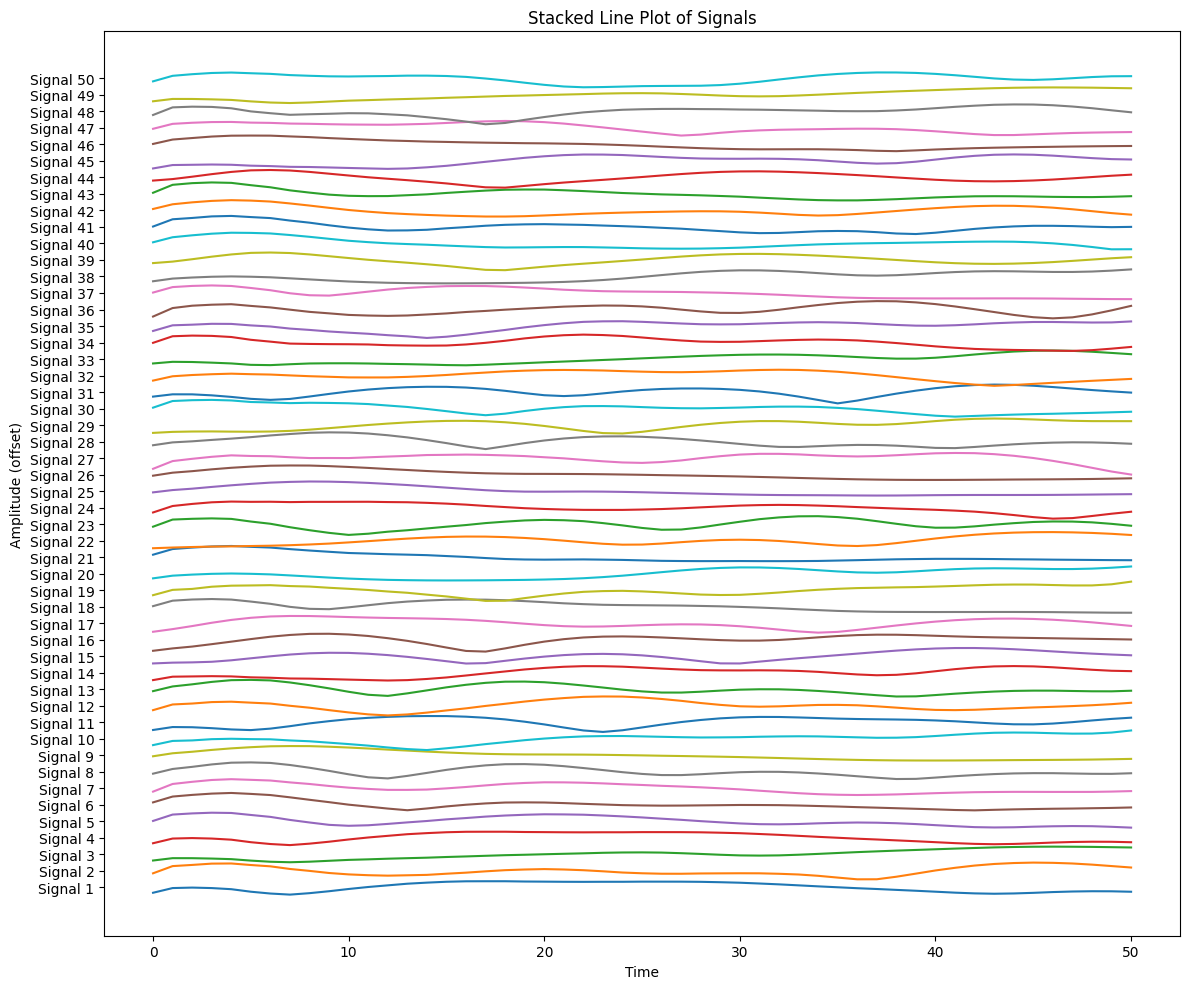

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data array is of shape (50, 107)
# Generate some sample data for demonstration
# For this example, we'll use 3 signals. You can extend this to 107 signals.
# data = np.random.rand(50, 3) * 2 - 1  # Random data between -1 and 1

data = eeg[0][:,np.random.choice(range(eeg[0].shape[-1]),50)]
n_samples, n_rows = data.shape[0], data.shape[-1]

# Time vector (assuming time points are evenly spaced)
time = np.arange(n_samples)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Define an offset for each signal
# Spacing between each signal is based on the max absolute value in the data
spacing = np.max(np.abs(data)) * 1.5  # Adjust 1.5 to control the space between signals

# Plot each signal with its respective offset
for i in range(n_rows):
    ax.plot(time, data[:, i] + i * spacing, label=f'Signal {i+1}')

# Set y-ticks to reflect the offset signals
ax.set_yticks(np.arange(n_rows) * spacing)
ax.set_yticklabels([f'Signal {i+1}' for i in range(n_rows)])  # Label signals

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude (offset)')
ax.set_title('Stacked Line Plot of Signals')

plt.tight_layout()
plt.show()

In [5]:
# Setting random seed for reproducibility
torch.manual_seed(42)

class Autoencoder(nn.Module):
    def __init__(self, input_size, seq_length):
        super(Autoencoder, self).__init__()
        
        print(f"\nNumber of channels: {input_size}")
        print(f"Length of sequence: {seq_length}")
        encoder_input_size = (2*input_size)-1
        self.input_size = input_size
        self.seq_length = seq_length

        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=seq_length, out_channels=100, kernel_size=input_size, padding="valid", stride=1),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=75, kernel_size=5, stride=2),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Conv1d(in_channels=75, out_channels=50, kernel_size=5, stride=2),
            nn.BatchNorm1d(50),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=50, out_channels=75, kernel_size=5, stride=2),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=75, out_channels=100, kernel_size=5, stride=2),
            nn.BatchNorm1d(100),
            nn.ReLU()
            )

        self.output_layer = nn.Sequential(
            nn.ConvTranspose1d(in_channels=100, out_channels=seq_length, kernel_size=int(input_size), stride=1),
            nn.BatchNorm1d(seq_length),
            nn.ReLU()
        ) 
        
    def forward(self, x):

        X_ext = torch.concat((x[:,:,:], x[:,:-1,:]), 1)
        print(X_ext.shape)
        
        X_in = self.input_layer(X_ext)
        print(f"X shape after input layer: ", X_in.shape)

        X_enc = self.encoder(X_in)
        print(f"X shape after encoder: ", X_enc.shape)

        X_dec = self.decoder(X_enc)
        print(f"X shape after decoder: ", X_dec.shape)

        X_out = self.output_layer(X_dec)
        print(f"X shape after output layer: ", X_out.shape)
        # X_output = X_out[:,:,:self.input_size]
        X_out_padded = torch.nn.functional.pad(X_out,(0,2,0,0,0,0), "constant",0)

        X_output = (X_out[:,:,:self.input_size] + X_out_padded[:,:,self.input_size:]) / 2

        return X_output

class Shallow_Autoencoder(nn.Module):
  def __init__(self, input_size, seq_length):
    super(Shallow_Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=100),
            nn.BatchNorm1d(seq_length),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=25),
            nn.BatchNorm1d(seq_length),
            nn.ReLU()
        )

    self.decoder = nn.Sequential(
            nn.Linear(in_features=25, out_features=100),
            nn.BatchNorm1d(seq_length),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=input_size),
            nn.BatchNorm1d(seq_length),
            nn.ReLU()
    )

  def forward(self, x):
    x_enc = self.encoder(x)
    x_dec = self.decoder(x_enc)

    return x_dec
  
class Basic_CNN(nn.Module):
  def __init__(self, input_size):
    super(Basic_CNN, self).__init__()
    print(f"Number of filters: {input_size}")

    self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=75, kernel_size=3, stride=1, padding="valid"),
            nn.BatchNorm1d(75),
            nn.GELU(),
            nn.Conv1d(in_channels=75, out_channels=50, kernel_size=3, stride=1, padding="valid"),
            nn.BatchNorm1d(50),
            nn.GELU(),
        )
    
    self.flatten = nn.Flatten()
    self.linear_enc = nn.Linear(2350, 2)
    self.linear_dec = nn.Linear(2, 2350)

    self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=50, out_channels=75, kernel_size=3, stride=1),
            nn.BatchNorm1d(75),
            nn.GELU(),
            nn.ConvTranspose1d(in_channels=75, out_channels=input_size, kernel_size=3, stride=1),
            # nn.BatchNorm1d(input_size)
            )

  def forward(self, x):
    x_enc = self.encoder(x)
    x_enc = self.flatten(x_enc)
    z = self.linear_enc(x_enc)
    z = self.linear_dec(z)
    z = z.reshape(z.shape[0], 50, 47)
    x_dec = self.decoder(z)


    return x_dec

In [6]:
class VAE(nn.Module):
  def __init__(self, input_size):
    super(VAE, self).__init__()
    print(f"Number of filters: {input_size}")

    self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=75, kernel_size=3, stride=1, padding="valid"),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Conv1d(in_channels=75, out_channels=50, kernel_size=3, stride=1, padding="valid"),
            nn.BatchNorm1d(50),
            nn.ReLU(),
        )
    
    self.flatten = nn.Flatten()
    self.linear_dec = nn.Linear(50, 2350)
    
    self.fc_mu = nn.Linear(2350, 50)
    self.fc_var = nn.Linear(2350, 50)

    self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=50, out_channels=75, kernel_size=3, stride=1),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=75, out_channels=input_size, kernel_size=3, stride=1),
            nn.BatchNorm1d(input_size),
            nn.ReLU()
            )

  def encode(self, x):
    x = self.encoder(x)
    x_flat = self.flatten(x)
    mu = self.fc_mu(x_flat)
    log_var = self.fc_var(x_flat)
    z = self.reparameterize(mu, log_var)
    return mu, log_var, z
  
  def decode(self, z):
    z = self.linear_dec(z)
    z = z.reshape(z.shape[0], 50, 47)
    x = self.decoder(z)
    return x
  
  def reparameterize(self, mu, logvar):
    
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = eps.mul(std).add_(mu)
    
    return z
  
  def forward(self, x):
    mu, log_var, z = self.encode(x)
    x = self.decode(z)
    return x, mu, log_var

In [7]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

# Model parameters:
LAYERS = 3
KERNELS = [5, 3, 2]
CHANNELS = [100, 75, 50]
STRIDES = [1, 1, 1]
LINEAR_DIM = 50
LINEAR_LAYER = False

class Encoder(nn.Module):
  def __init__(self, input_size, seq_len, use_batchnorm=False, use_dropout=False, act_func=nn.ReLU()):
    super(Encoder, self).__init__()
    
    self.seq_len = seq_len
    self.input_size = input_size
    self.length_arr = []
    
    # bottleneck dimentionality
    self.latent_dim = CHANNELS[-1]

    # variables deciding if using dropout and batchnorm in model
    self.use_dropout = use_dropout
    self.use_batchnorm = use_batchnorm
    self.act_func = act_func

    # convolutional layer hyper parameters
    self.layers = LAYERS
    self.kernels = KERNELS
    self.channels = CHANNELS
    self.strides = STRIDES


    self.net = self.get_arch()
    
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(int(CHANNELS[-1]*self.length_arr[-1]), LINEAR_DIM)
  
  def get_arch(self):        
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            
            if (i == 0): 
               conv_layers.append(nn.Conv1d(in_channels=self.input_size, 
                                            out_channels=self.channels[i], 
                                            kernel_size=self.kernels[i],
                                            stride=self.strides[i],
                                            padding="valid"))
               
               self.length_arr.append(calculate_output_length(self.seq_len, self.kernels[i], stride=self.strides[i]))
               
            else: 
               conv_layers.append(nn.Conv1d(in_channels=self.channels[i-1], 
                                         out_channels=self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding="valid"))
               self.length_arr.append(calculate_output_length(self.length_arr[i-1], self.kernels[i], stride=self.strides[i]))
            
            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm1d(self.channels[i]))
            
            conv_layers.append(self.act_func) 

            
        return conv_layers
  
  def forward(self, x):
    x = self.net(x)
    if LINEAR_LAYER:
      x = self.flatten(x)
      x = self.linear(x)
    return x
  
class Decoder(nn.Module):
  def __init__(self, input_size, latent_len, use_dropout=False, use_batchnorm=False, act_func=nn.ReLU()):
    super(Decoder, self).__init__()

    self.linear = nn.Linear(LINEAR_DIM, int(CHANNELS[-1]*latent_len))
    self.latent_dim = CHANNELS[-1]
    self.latent_len = latent_len
    self.input_size = input_size
    
    # variables deciding if using dropout and batchnorm in model
    self.use_dropout = use_dropout
    self.use_batchnorm = use_batchnorm

    # convolutional layer hyper parameters
    self.layers = LAYERS
    self.kernels = KERNELS
    self.channels = CHANNELS
    self.strides = STRIDES

    # activation function
    self.act_func = act_func

    self.net = self.get_arch()
    
  def get_arch(self):        
      conv_layers = nn.Sequential()
      for i in reversed(range(self.layers)):
          if (i == 0): 
              conv_layers.append(nn.ConvTranspose1d(in_channels=self.channels[i], 
                                                    out_channels=self.input_size, 
                                                    kernel_size=self.kernels[i],
                                                    stride=self.strides[i]))     
              # if self.use_batchnorm:
                # conv_layers.append(nn.BatchNorm1d(self.input_size))         
          else: 
              conv_layers.append(nn.ConvTranspose1d(in_channels=self.channels[i], 
                                                    out_channels=self.channels[i-1],
                                                    kernel_size=self.kernels[i],
                                                    stride=self.strides[i]))
              if self.use_batchnorm:
                 conv_layers.append(nn.BatchNorm1d(self.channels[i-1]))
              conv_layers.append(self.act_func) 

          
      return conv_layers
  
  def forward(self, x):
    if LINEAR_LAYER:
      x = self.linear(x)
      x = x.reshape(x.shape[0], self.latent_dim, self.latent_len)
    x = self.net(x)
    return x
  
class AE_Basic(nn.Module):
    
    def __init__(self, input_size, seq_len, use_batchnorm=False, act_func=nn.ReLU()):
        super(AE_Basic, self).__init__()
        self.encoder = Encoder(input_size,seq_len, use_batchnorm=use_batchnorm, act_func=act_func)
        self.decoder = Decoder(input_size, self.encoder.length_arr[-1], use_batchnorm=use_batchnorm, act_func=act_func)
        
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [17]:
n_batches = 1024

X_train, X_test, y_train, y_test = train_test_split(zscore(eeg, axis=1), labels, test_size=0.05, shuffle=True)

training_dataset = EegDataset(X_train, y_train)
testing_dataset = EegDataset(X_test, y_test)

training_dataloader = DataLoader(dataset=training_dataset, batch_size=n_batches, shuffle=False)
testing_dataloader = DataLoader(dataset=testing_dataset, batch_size=n_batches, shuffle=False)

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

# Model Initialization
# autoencoder = VAE(input_size=training_dataset.eeg_tensor.shape[2], seq_len=training_dataset.eeg_tensor.shape[1], 
#                        use_batchnorm=True)
autoencoder = VAE(input_size=training_dataset.eeg_tensor.shape[2])
autoencoder = autoencoder.to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr = 1e-3)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.1, patience=5, verbose=True
# )


cuda:0
Number of filters: 107


In [19]:
def loss_fn(X_rec, X_batch, mu, logvar):
    MSE = F.mse_loss(X_rec, X_batch)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD

n_epochs = 50
epoch_loss = []

for epoch in range(n_epochs):
    autoencoder.train()
    running_loss_arr = []
    running_loss = 0
    training_loop = tqdm(enumerate(training_dataloader), total=len(training_dataloader), leave=False)
    for batch_idx, (X_batch, _) in training_loop:

        X_batch = X_batch.permute(0, 2, 1) # batch x channels x length 
        X_batch = X_batch.to(device)
        # print(X_batch.shape)
        # X_rec = autoencoder(X_batch)
        X_rec, mean, log_var = autoencoder(X_batch)

        # loss = loss_function(X_rec, X_batch)
        loss, mse, kld = loss_fn(X_batch, X_rec, mean, log_var)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss_arr.append(loss.item())
        running_loss += loss.item() * X_batch.shape[0]
        
        # update progress bar
        training_loop.set_description(f"Epoch {epoch+1}/{n_epochs}")
        training_loop.set_postfix(loss=loss.item())
    epoch_loss.append(running_loss / n_batches)


<Axes: >

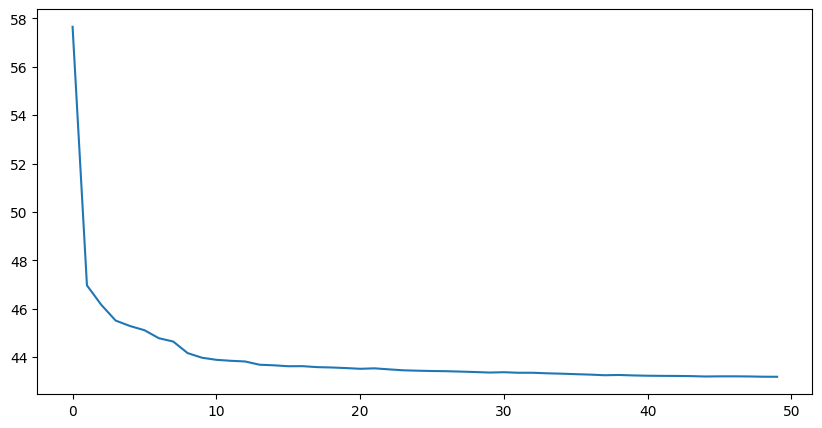

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(epoch_loss, ax=ax)


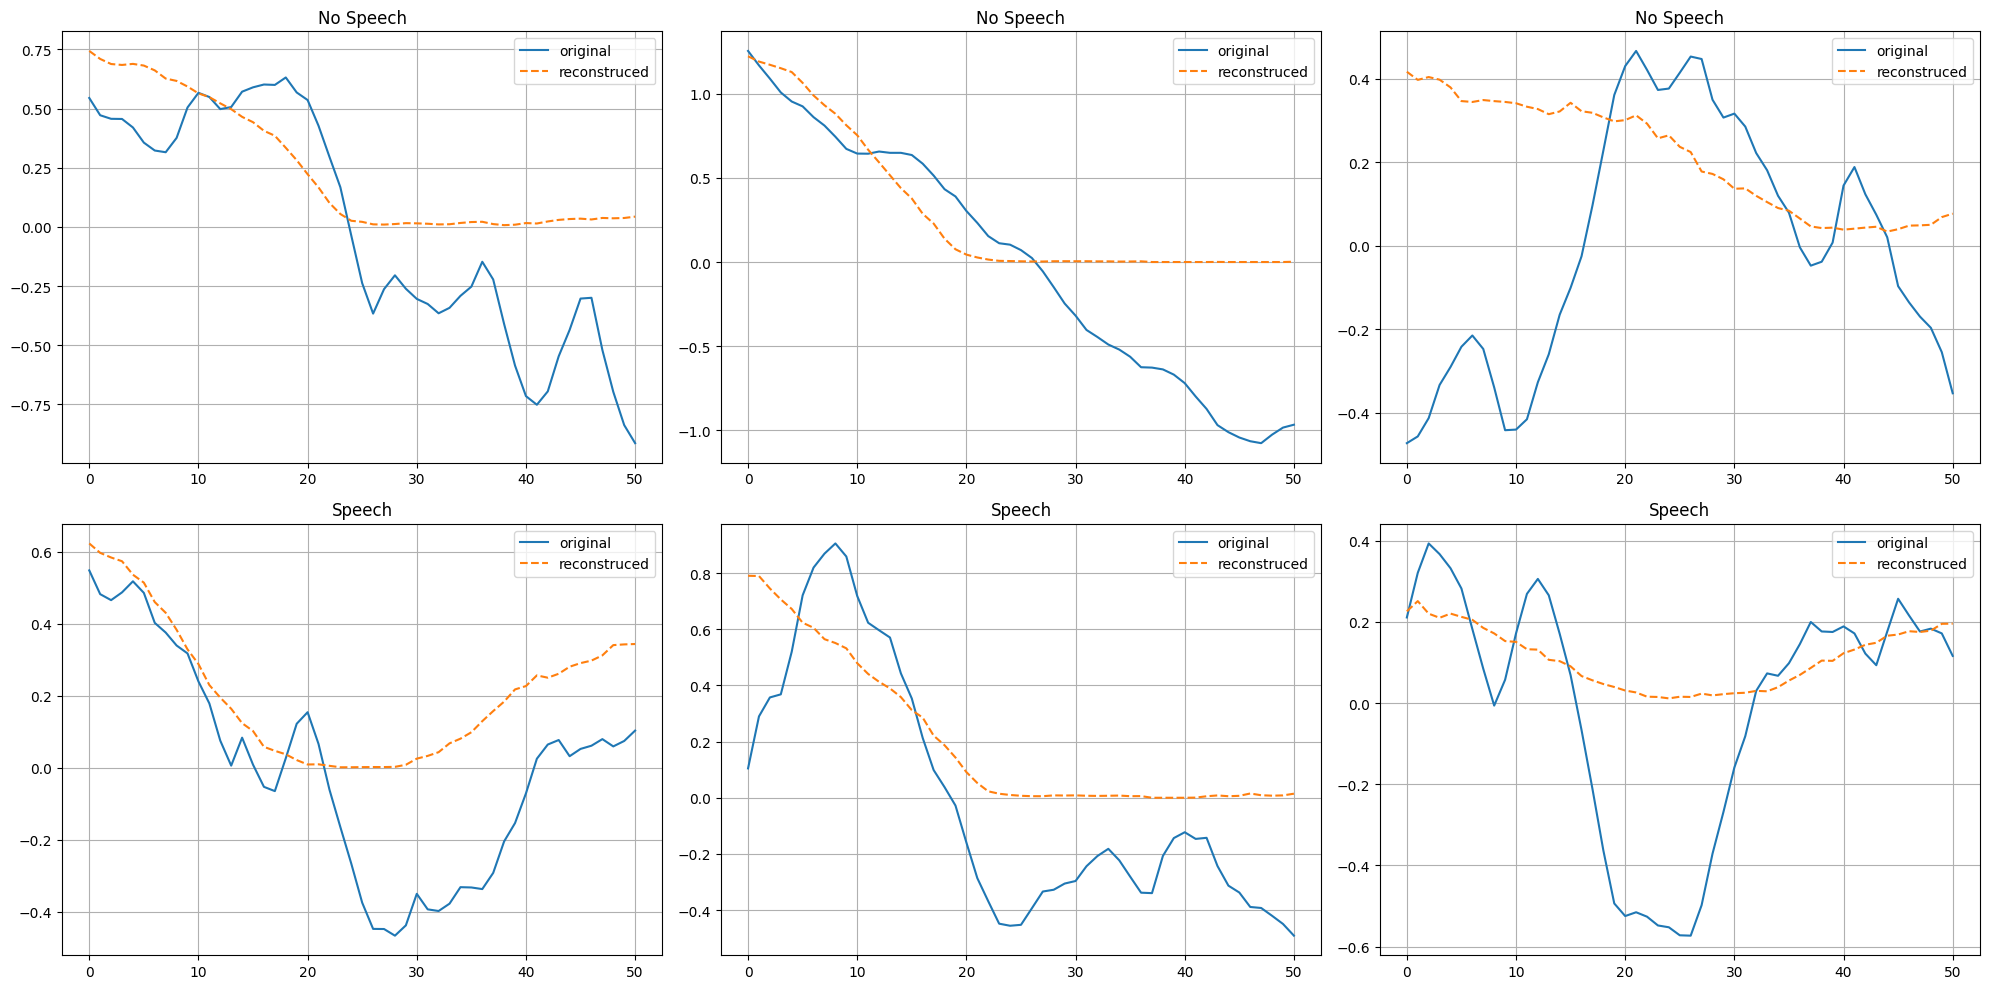

In [22]:
y_rest = np.random.choice(np.where(y_test==0)[0],3)
y_active = np.random.choice(np.where(y_test==1)[0],3)


X_test = testing_dataset.eeg_tensor[:,:,:].permute(0,2,1)
X_test = X_test.to(device)

X_reconstruction = autoencoder(X_test)[0].to("cpu").detach().numpy()
X_test = X_test.to("cpu")

X_test_mean = X_test.mean(1)
X_reconstruction_mean = X_reconstruction.mean(1)

fig, axs = plt.subplots(2,3,figsize=(20,10),tight_layout=True)

for ax_idx, rest_idx in enumerate(y_rest):
    sns.lineplot(X_test_mean[rest_idx], label="original", ax=axs[0][ax_idx]);
    sns.lineplot(X_reconstruction_mean[rest_idx], label="reconstruced", ax=axs[0][ax_idx], linestyle='--');
    axs[0][ax_idx].set_title("No Speech")
    axs[0][ax_idx].grid()

for ax_idx, act_idx in enumerate(y_active):
    sns.lineplot(X_test_mean[act_idx], label="original", ax=axs[1][ax_idx]);
    sns.lineplot(X_reconstruction_mean[act_idx], label="reconstruced", ax=axs[1][ax_idx], linestyle='--');
    axs[1][ax_idx].set_title("Speech")
    axs[1][ax_idx].grid()

In [23]:
class DenseCLF(nn.Module):

    def __init__(self, input_size, output_size):
        super(DenseCLF, self).__init__()
        
        self.fc1 = nn.Sequential(nn.Linear(input_size, 64),
                                nn.BatchNorm1d(64),
                                nn.ReLU())
        
        self.fc2 = nn.Sequential(nn.Linear(64, 32),
                                nn.BatchNorm1d(32),
                                nn.ReLU())
        
        self.fc3 = nn.Sequential(nn.Linear(32, output_size),
                                nn.BatchNorm1d(output_size),
                                nn.ReLU())
    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    
class CnnCLF(nn.Module):

    def __init__(self, input_size, output_size):
        super(CnnCLF, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=input_size, out_channels=75, kernel_size=5),
                                nn.BatchNorm1d(75),
                                nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=75, out_channels=50, kernel_size=5),
                                nn.BatchNorm1d(50),
                                nn.ReLU())
        
        self.fc1 = nn.Sequential(nn.Linear(32, 32),
                                nn.BatchNorm1d(output_size),
                                nn.ReLU())
        
        self.fc2 = nn.Sequential(nn.Linear(32, output_size),
                                nn.BatchNorm1d(output_size),
                                nn.ReLU())
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

def train_clf_model(model, n_epochs, dataloader):
    epoch_loss = []
    for epoch in range(n_epochs):
        running_loss_arr = []
        running_loss = 0

        training_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
        for _, (X_batch, y_batch) in training_loop:

            y_pred = model(X_batch)
            loss = loss_function(y_batch.to(torch.float).reshape(-1,1), y_pred)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss_arr.append(loss.item())
            running_loss += loss.item() * X_batch.shape[0]
            
            # update progress bar
            training_loop.set_description(f"Epoch {epoch+1}/{n_epochs}")
            training_loop.set_postfix(loss=loss.item())
        epoch_loss.append(running_loss / n_batches)


    return model, epoch_loss

# Classifier without dimensionality reduction

## Logistic Regression

(9965, 107)
0.7661816357250376
0.7521324636226794
0.7556447566482689
0.7536377320622177
0.7591570496738586


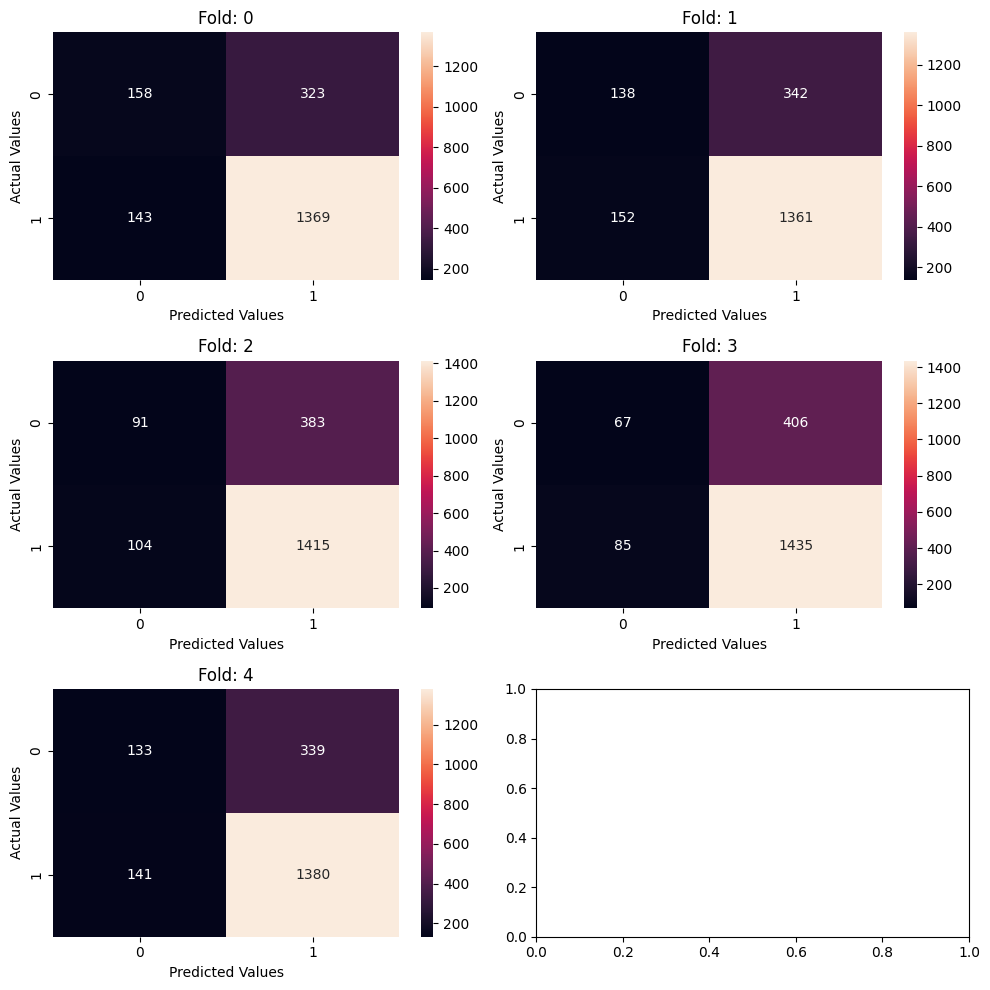

In [16]:
data = eeg.mean(axis=1)
print(data.shape)

nfolds = 5
kf = KFold(nfolds, shuffle=False)
fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data)):
    
    # create training and testing datasets
    X_train = zscore(data[train, :], axis=0)
    X_test = zscore(data[test, :], axis=0)

    # Create and train the classifier
    clf = LogisticRegression().fit(X_train, labels[train])

    # Make predictions
    y_pred = clf.predict(X_test)
    print(accuracy_score(labels[test], y_pred))
    
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")

## Dense NN

0.787021297870213


0.7874


0.7902


0.7672


0.7907


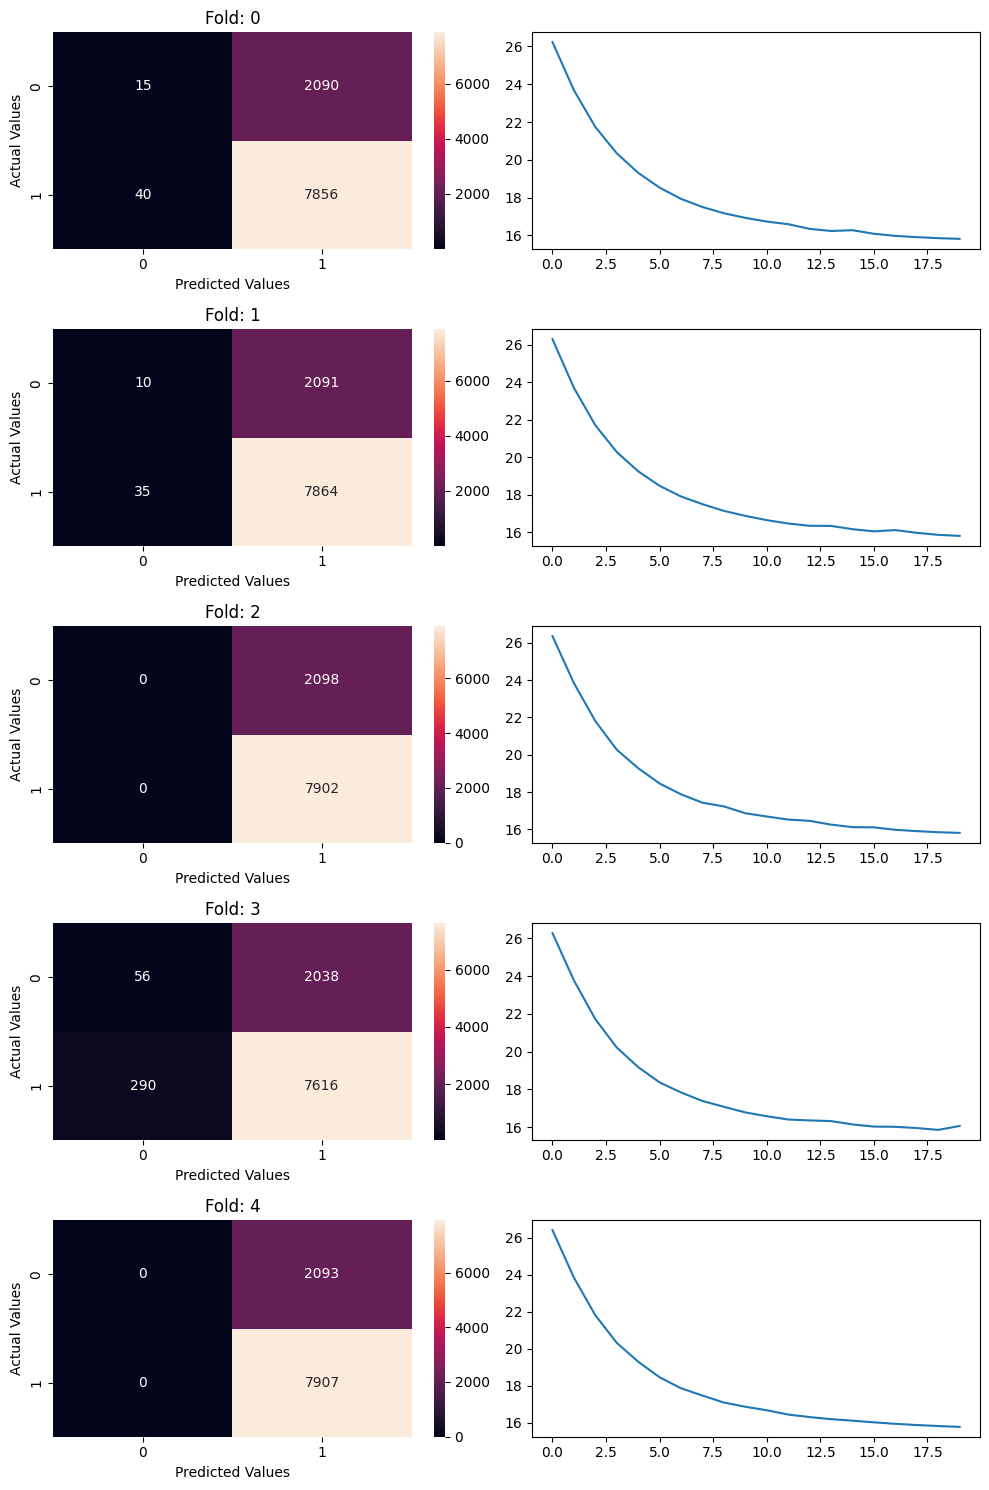

In [84]:
model.eval()
classification_dataset = EegDataset(eeg, labels)
data = classification_dataset.eeg_tensor.permute(0,2,1)
# with torch.no_grad():
#     data_encoded = model.encoder(data).to("cpu")

input_size = (data.shape[1]*data.shape[2])
output_size = 1

nfolds = 5
n_epochs = 20
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(5,2,figsize=(10,15), tight_layout=True)

for k, (train, test) in enumerate(kf.split(data)):
    
    clf_model = DenseCLF(input_size, output_size)

    # Validation using MSE Loss function
    loss_function = nn.BCEWithLogitsLoss() 

    # Using an Adam Optimizer with lr = 0.1
    optimizer = torch.optim.Adam(clf_model.parameters(),
                                lr = 1e-2)
    
    # create training and testing datasets
    classification_dataset.eeg_tensor = data[train, :]
    classification_dataset.y = labels[train]
    train_dataloader = DataLoader(dataset=classification_dataset, batch_size=1024, shuffle=False)
    
    
    clf_model, epoch_loss = train_clf_model(clf_model, n_epochs=n_epochs, dataloader=train_dataloader)

    clf_model.eval()
    with torch.no_grad():
        y_pred = clf_model(data[test, :])
    y_pred = y_pred.round()

    print(accuracy_score(labels[test], y_pred))
    # Plot Loss
    sns.lineplot(epoch_loss, ax=axs[k,1])
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k,0], fmt="")
    axs[k,0].set_title(f"Fold: {k}")
    axs[k,0].set_ylabel("Actual Values")
    axs[k,0].set_xlabel("Predicted Values")


# Classifier with PCA

## Logistic Regression

0.8751529274686862
0.8848817906004923
0.8795325657329438
0.881654100982408
0.8801760583772514


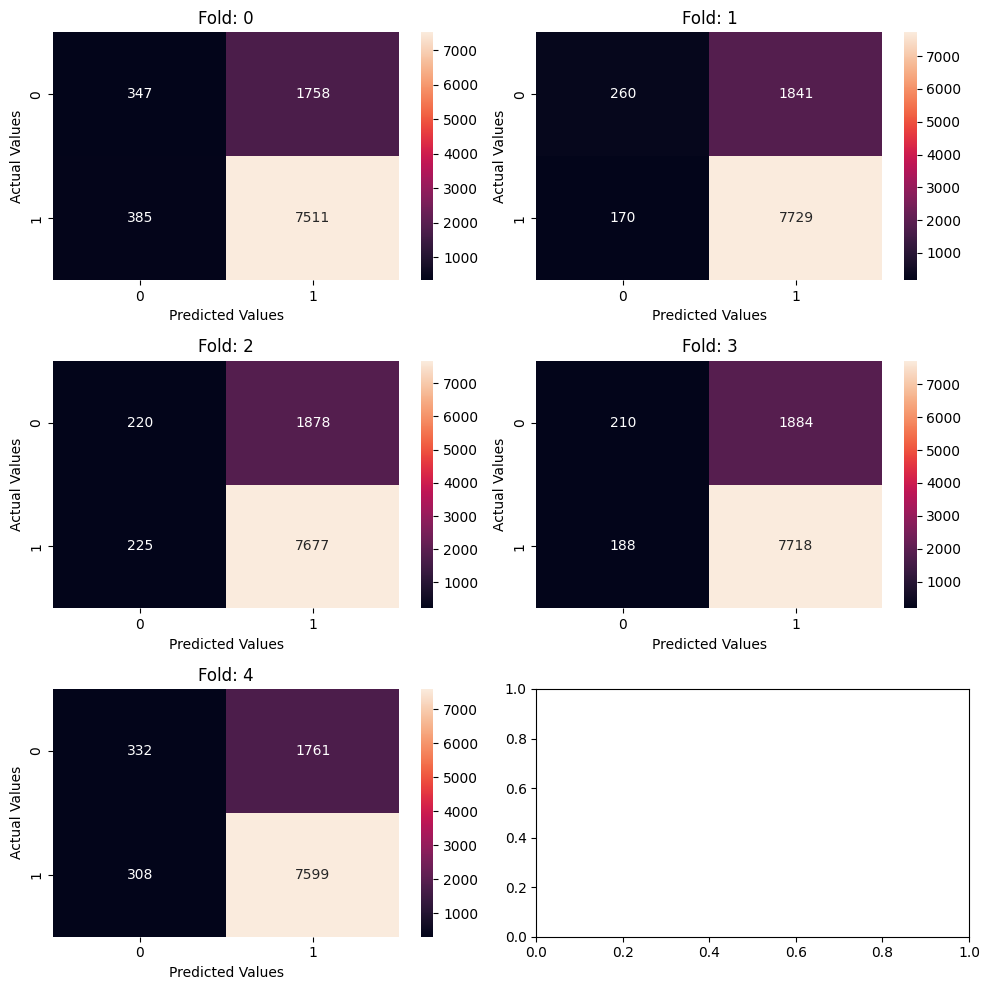

In [14]:
data = eeg.mean(axis=1)

pca = PCA()
numComps = 50

nfolds = 5
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data)):
    
    # create training and testing datasets
    X_train = zscore(data[train, :], axis=0)
    X_test = zscore(data[test, :], axis=0)

    #Fit PCA to training data
    pca.fit(X_train)

    #Get percentage of explained variance by selected components
    # print(np.sum(pca.explained_variance_ratio_[:numComps]))

    #Tranform data into component space
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    clf = LogisticRegression().fit(X_train, labels[train])

    y_pred = clf.predict(X_test)
    print(f1_score(labels[test], y_pred))
    
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")


# Classifier with encoder dimensionality reduction

## Logistic Regression


Class 0 F1: 0.35
Average F1: 0.07
Overall Accuracy: 0.21

Class 0 F1: 0.35
Average F1: 0.07
Overall Accuracy: 0.21

Class 0 F1: 0.35
Average F1: 0.07
Overall Accuracy: 0.21

Class 0 F1: 0.35
Average F1: 0.07
Overall Accuracy: 0.21

Class 0 F1: 0.35
Average F1: 0.07
Overall Accuracy: 0.21


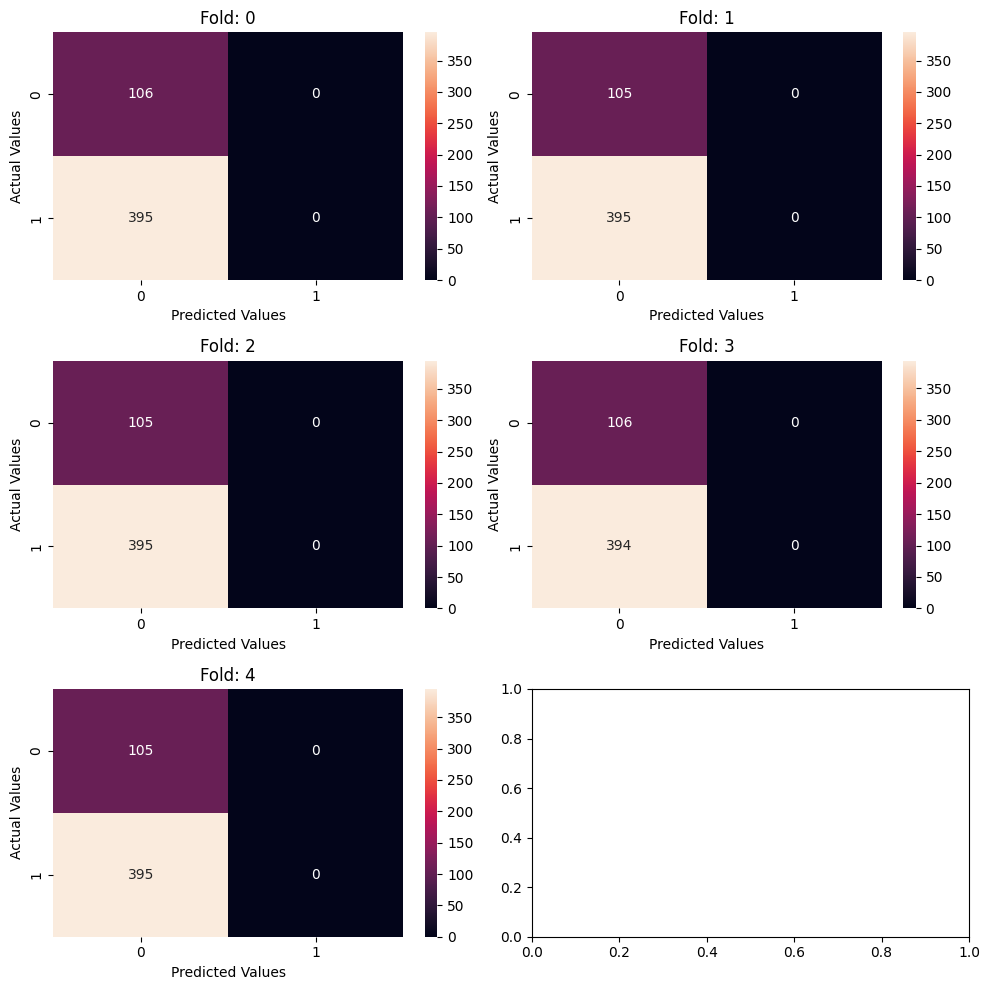

In [23]:
autoencoder.eval()
data = testing_dataset.eeg_tensor.to(device).permute(0,2,1)
with torch.no_grad():
    data_encoded = autoencoder.encoder(data).to("cpu")
data_encoded = data_encoded.view(data_encoded.size(0),-1)
nfolds = 5
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data_encoded)):
    
    # create training and testing datasets
    X_train = data_encoded[train, :]
    X_test = data_encoded[test, :]

    clf = svm.SVC(max_iter=500, class_weight="balanced").fit(X_train, labels[train])

    y_pred = clf.predict(X_test)
    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")


## Dense NN

0.0


0.0


0.0


0.0


0.0


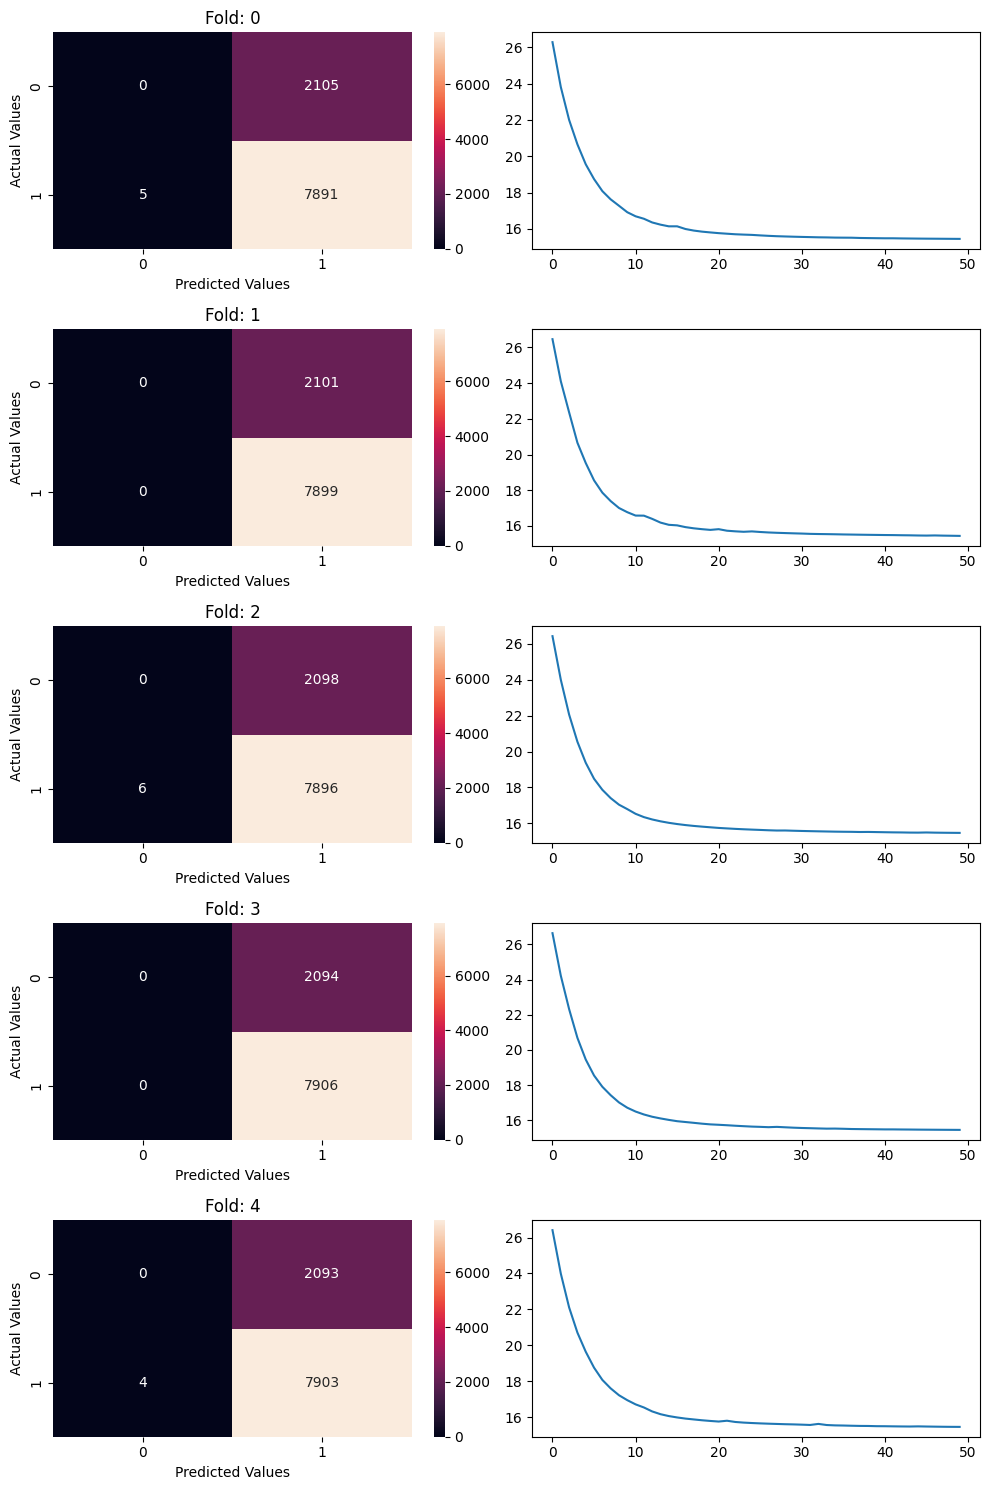

In [15]:
autoencoder.eval()
classification_dataset = EegDataset(eeg, labels)
data = classification_dataset.eeg_tensor.to(device).permute(0,2,1)
with torch.no_grad():
    data_encoded = autoencoder.encode(data)[2].to("cpu")

input_size = (data_encoded.shape[1])
output_size = 1

nfolds = 5
n_epochs = 50
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(5,2,figsize=(10,15), tight_layout=True)

for k, (train, test) in enumerate(kf.split(data_encoded)):
    clf_model = DenseCLF(input_size, output_size)

    # Validation using MSE Loss function
    loss_function = nn.BCEWithLogitsLoss() 

    # Using an Adam Optimizer with lr = 0.1
    optimizer = torch.optim.Adam(clf_model.parameters(),
                                lr = 1e-2)
    
    # create training dataset
    fold_dataset = EegDataset(data_encoded[train, :], labels[train])
    train_dataloader = DataLoader(dataset=fold_dataset, batch_size=1024, shuffle=False)
    
    clf_model, epoch_loss = train_clf_model(clf_model, n_epochs=n_epochs, dataloader=train_dataloader)

    clf_model.eval()
    with torch.no_grad():
        y_pred = clf_model(data_encoded[test, :])
    y_pred = y_pred.round()

    print(f1_score(labels[test], y_pred, pos_label=0))
    # Plot Loss
    sns.lineplot(epoch_loss, ax=axs[k,1])
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k,0], fmt="")
    axs[k,0].set_title(f"Fold: {k}")
    axs[k,0].set_ylabel("Actual Values")
    axs[k,0].set_xlabel("Predicted Values")


In [129]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1


n = 107
l = 51
input_a = torch.rand(1,n,l)
print(input_a.shape)

conv_lay_1 = nn.Conv1d(in_channels=n,out_channels=75,kernel_size=3,stride=1, padding="valid")
output_1 = conv_lay_1(input_a)
print(output_1.shape)
print(calculate_output_length(51, 3))

conv_lay_2 = nn.Conv1d(in_channels=75, out_channels=50,kernel_size=3,stride=1, padding="valid")
output_2 = conv_lay_2(output_1)

# flat_lay = nn.Flatten()
# output_2_flat = flat_lay(output_2)
print(output_2.shape)
print(calculate_output_length(49, 3))
# print(output_2_flat.shape)

# pool_lay_avg = nn.AvgPool1d(47)
# lat_feat_1 = pool_lay_avg(output_2)
# print(f"Latent features: {lat_feat_1.shape}")


# pool_lay_max = nn.MaxPool1d(47)
# lat_feat_2 = pool_lay_max(output_2)
# print(f"Latent features: {lat_feat_2.shape}")


# deconv_lay_1 = nn.ConvTranspose1d(in_channels=50, out_channels=75,kernel_size=3,stride=1)
# output_3 = deconv_lay_1(output_2)
# print(output_3.shape)

# deconv_lay_2 = nn.ConvTranspose1d(in_channels=75, out_channels=n,kernel_size=3, stride=1)
# output_4 = deconv_lay_2(output_3)
# print(output_4.shape)

torch.Size([1, 107, 51])
torch.Size([1, 75, 49])
49
torch.Size([1, 50, 47])
47
